In [1]:
import os
os.chdir("../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(2)


In [3]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import tqdm
from flax.training import train_state
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot

import tensorflow_probability.substrates.jax as tfp

dist = tfp.distributions

from datasets.dataset_loader import dataset_load
from utilities import plot,fits,gmm,errors,predict,preprocess


In [4]:
train ={ 
    1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {
     2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [6]:
x_train, y_train, x_test, y_test, x_test_timestamp, scaler_x, scaler_y = dataset_load(appliances, train, test)

In [12]:
class seq2point(nn.Module):
    @nn.compact
    def __call__(self, X, deterministic):
        X = nn.Conv(30, kernel_size=(10,))(X)
        X = nn.relu(X)
        X = nn.Conv(30, kernel_size=(8,))(X)
        X = nn.relu(X)        
        X = nn.Conv(40, kernel_size=(6,))(X)
        X = nn.relu(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = X.reshape((X.shape[0], -1))
        X = nn.Dense(1024)(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Dense(1)(X)
    
        return X
        
    def loss_fn(self, params, X, y, deterministic, rng):
        yhat = model.apply(params, X, deterministic, rngs={"dropout":rng})
        loss = jnp.mean((y - yhat)**2)
        return loss

In [13]:
model = seq2point()

In [14]:
params =  model.init(jax.random.PRNGKey(0), jnp.ones([1, 19, 1]), True)

In [15]:
%%time
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.001, epochs=20)

CPU times: user 12.7 s, sys: 3.25 s, total: 15.9 s
Wall time: 8.33 s


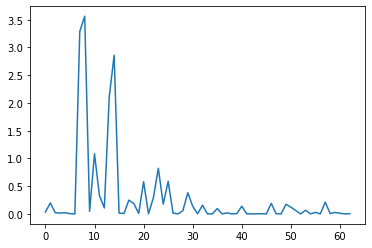

In [16]:
plt.plot(losses[::100])

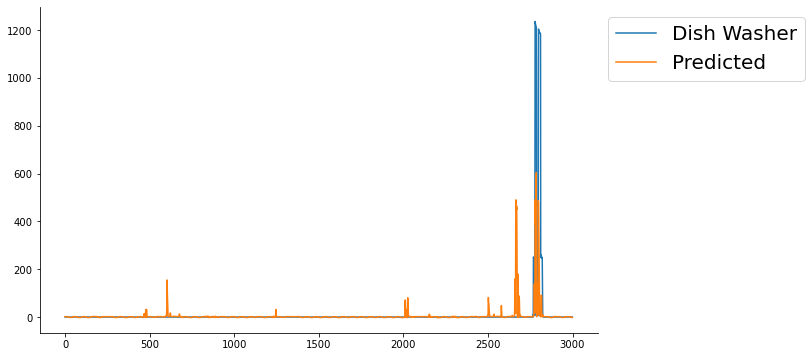

In [19]:
idx = 3000
yhat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Dish Washer")
plt.plot(jnp.arange(idx), scaler_y.inverse_transform(yhat[:idx]), label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("seq2point.pdf", bbox_inches="tight")

## GMLP

In [12]:
class seq2gpoint(nn.Module):
    @nn.compact
    def __call__(self, X, deterministic):
        X = nn.Conv(30, kernel_size=(10,))(X)
        X = nn.relu(X)
        X = nn.Conv(30, kernel_size=(8,))(X)
        X = nn.relu(X)        
        X = nn.Conv(40, kernel_size=(6,))(X)
        X = nn.relu(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = X.reshape((X.shape[0], -1))
        X = nn.Dense(1024)(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Dense(2)(X)
        mean = X[:, 0]
        sigma = nn.softplus(X[:, 1])
        return mean, sigma
    
    def loss_fn(self, params, X, y, deterministic, rng=jax.random.PRNGKey(0)):
        mean, sigma = self.apply(
            params, X, deterministic=deterministic, rngs={"dropout": rng}
        )

        def loss(mean, sigma, y):
            d = dist.Normal(loc=mean, scale=sigma)
            return -d.log_prob(y)

        return jnp.mean(jax.vmap(loss, in_axes=(0, 0, 0))(mean, sigma, y))

In [13]:
model = seq2gpoint()
params =  model.init(jax.random.PRNGKey(0), x_train, True)

In [14]:
%%time
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.0001, epochs=50)

CPU times: user 21.3 s, sys: 3.65 s, total: 24.9 s
Wall time: 17.3 s


In [15]:
losses[-1]

DeviceArray(-5.212321, dtype=float32)

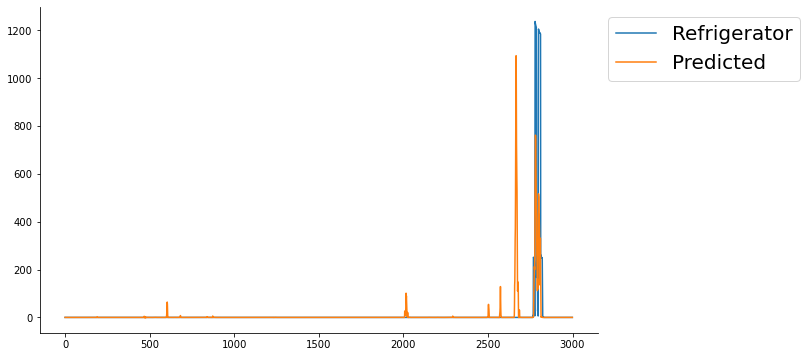

In [16]:
idx = 3000
yhat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), y_test[:idx], label = "Refrigerator")
plt.plot(jnp.arange(idx), scaler_y.inverse_transform(yhat[0][:idx].reshape(-1,1)), label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
plt.savefig("seq2point.pdf", bbox_inches="tight")

## MC Dropout

In [17]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

In [18]:
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

In [19]:
mean, sigma = gmm.gmm_mean_var(mean_stacks, sigma_stacks)

In [20]:
mean = scaler_y.inverse_transform(mean.reshape(-1,1)).squeeze()
sigma = scaler_y.scale_*sigma

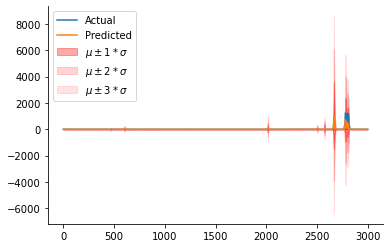

In [26]:
ax = plot.plot(3000,y_test,mean,sigma)
ax.legend(loc="upper left")

Text(0.5, 1.0, '2.1560')

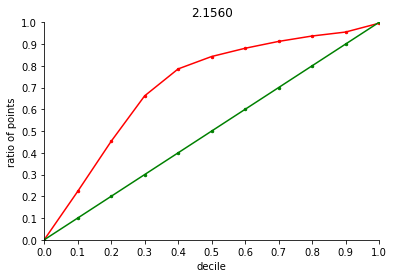

In [22]:
fig, ax = plt.subplots(1)
df,df2 = plot.calibration_regression(mean, sigma, y_test, "test", "r", ax)
ax.set_title(f'{errors.ace(df2):.4f}')

NameError: ignored

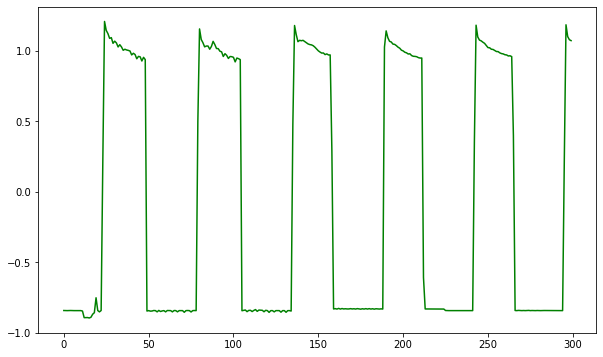

In [ ]:
idx = 300
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx), scaler_y.transform(y_test[:idx].reshape(-1,1)), label = "Refrigerator", color="green")
plt.plot(jnp.arange(idx), mean[:idx], label = "Predicted")
for i in range(1,4):
    plt.fill_between(jnp.arange(idx), mean[:idx] - i*sigma[:idx], mean[:idx] + i*sigma[:idx],
                    color="orange", alpha=(1/(i*3)), label=f"$\mu\pm{i}*\sigma$")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
plt.ylabel("Power", fontsize=20)
sns.despine()
# plt.savefig("seq2pointUncertain_wd.pdf", bbox_inches="tight")

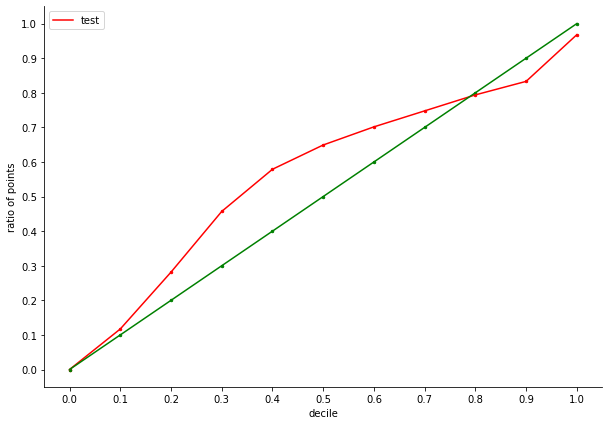

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7))
r = plot.calibration_regression(mean, sigma, scaler_y.transform(y_test.reshape(-1,1)), "test", "r", ax)